In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
from PIL import Image

# Variables

In [2]:
DATASET_DIR = "/media/luchocode/Extra vol/ExoNet_Images/ExoNet_Images"
DATASET_LABELS_FILE = "/home/luchocode/Downloads/Labels.csv"

# Preprocesar el dataset ExoNet

In [3]:
labels = pd.read_csv(DATASET_LABELS_FILE)
labels.head()

,video,frame,class
0,IMG_03_1,0,LG-T-DW
1,IMG_03_1,6,LG-T-O
2,IMG_03_1,12,LG-T-O
3,IMG_03_1,18,LG-T-O
4,IMG_03_1,24,LG-T-O


In [4]:
# Eliminando registros de "labels" que no exista imágenes
labels["exist"] = labels.apply(lambda row: os.path.exists(os.path.join(DATASET_DIR,f"{row[2]}",f"['{row[0]}'] frame {row[1]}.jpg")), axis=1)
labels.info()

/tmp/ipykernel_6678/2064144904.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  labels["exist"] = labels.apply(lambda row: os.path.exists(os.path.join(DATASET_DIR,f"{row[2]}",f"['{row[0]}'] frame {row[1]}.jpg")), axis=1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 922790 entries, 0 to 922789
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   video   922790 non-null  object
 1   frame   922790 non-null  int64 
 2   class   922790 non-null  object
 3   exist   922790 non-null  bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 22.0+ MB


In [5]:
labels.head()

,video,frame,class,exist
0,IMG_03_1,0,LG-T-DW,True
1,IMG_03_1,6,LG-T-O,True
2,IMG_03_1,12,LG-T-O,True
3,IMG_03_1,18,LG-T-O,True
4,IMG_03_1,24,LG-T-O,True


In [6]:
df_labels = labels[labels["exist"]==True]
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 922782 entries, 0 to 922788
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   video   922782 non-null  object
 1   frame   922782 non-null  int64 
 2   class   922782 non-null  object
 3   exist   922782 non-null  bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 29.0+ MB


In [7]:
def show_images_in_grid(image_paths, cols=3, figsize=(12, 8)):
    """
    Display images in a grid layout.

    Args:
        image_paths (list[str]): List of image file paths.
        cols (int): Number of columns in the grid.
        figsize (tuple): Size of the figure.
    """
    n_images = len(image_paths)
    rows = math.ceil(n_images / cols)

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten() if rows * cols > 1 else [axes]

    for ax, img_path in zip(axes, image_paths):
        try:
            img = Image.open(img_path)
            ax.imshow(img)
            ax.set_title(img_path.split("/")[-1], fontsize=8)
            ax.axis("off")
        except Exception as e:
            ax.text(0.5, 0.5, f"Error\n{e}", ha="center", va="center")
            ax.axis("off")

    # Hide empty subplots if any
    for ax in axes[n_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

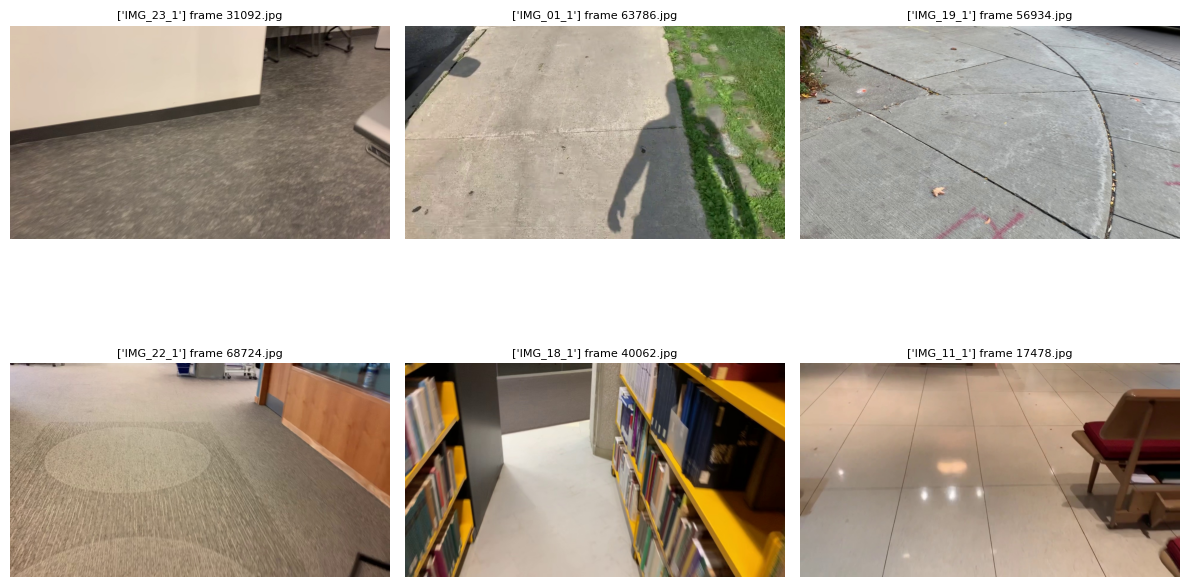

In [8]:
random_images = [os.path.join(DATASET_DIR,f"{row[2]}",f"['{row[0]}'] frame {row[1]}.jpg") for row in df_labels.sample(6).to_numpy()]
show_images_in_grid(random_images)

In [9]:
# Counting the number of frames per video
df_video = df_labels.groupby(['video'])['video'].count()
df_video.head()

video
IMG_01_1    19436
IMG_01_2    11074
IMG_01_3    18078
IMG_01_4     8956
IMG_02_1    16641
Name: video, dtype: int64

In [10]:
df_class = df_labels.groupby(['class'])['class'].count()
df_class

class
DS-T-LG     28677
DW-S        36710
DW-T-O      19150
IS-S        17357
IS-T-DW     31628
IS-T-LG     11040
LG-S        77576
LG-T-DS     22607
LG-T-DW    379195
LG-T-IS     26067
LG-T-O     153260
LG-T-SE    119515
Name: class, dtype: int64

In [11]:
# Regenerate a video sequence
import cv2
import os

def frames_to_video(frames, output_path, fps=30):
    """
    Args:
        frames (list of numpy arrays): list of frames (H, W, C) in RGB or BGR
        output_path (str): path to save the video (e.g. 'output.mp4')
        fps (int): frames per second
    """
    if len(frames) == 0:
        raise ValueError("No frames provided")

    # Get frame size
    height, width, channels = frames[0].shape

    # Define video codec and writer
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # or "XVID", "avc1"
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        # If frames are RGB (from PIL/torchvision), convert to BGR for OpenCV
        if frame.shape[2] == 3:
            frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        else:
            frame_bgr = frame
        out.write(frame_bgr)

    out.release()
    print(f"Video saved to {output_path}")

def regenerate_video(df, video_name, image_dir):
    df_video = df[df['video'] == video_name].sort_values(by='frame')
    frames = [np.array(Image.open(os.path.join(image_dir, f"{row[2]}", f"['{row[0]}'] frame {row[1]}.jpg"))) for row in df_video.to_numpy()]
    frames_to_video(frames, f"{video_name}.mp4")


In [12]:
regenerate_video(df_labels, 'IMG_01_1', DATASET_DIR)

Video saved to IMG_01_1.mp4


In [15]:
def play_video(video_path):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error: Could not open video {video_path}")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        cv2.imshow('Video', frame)

        # Press 'q' to exit the video early
        if cv2.waitKey(30) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

In [16]:
play_video('IMG_01_1.mp4')

## Creando un dataset personalizado

In [17]:
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class ExoNetDataset(Dataset):
    def __init__(
        self,
        df_labels: pd.DataFrame,
        img_dir: str,
        transform=None,
        target_transform=None
    ):
        self.img_labels = df_labels
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        """
        Return an image and its label
        """
        file_name = f"['{self.img_labels[idx, 0]}'] frame {self.img_labels[idx, 1]}.jpg"
        img_path = os.path.join(
            self.img_dir,
            self.img_labels.iloc(idx, 2),
            file_name
        )
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 2]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            image = self.target_transform

        return image, label

In [14]:
from torch.utils.data import DataLoader

# train_dataloader = 